# 그래프 생성

LangGraph는 에이전트 워크플로우를 그래프로 모델링합니다. 그래프는 노드(Node)와 엣지(Edge)로 구성되며, 상태(State)를 통해 데이터가 노드 간에 전달됩니다.

이 튜토리얼에서는 LangGraph의 핵심 구성 요소인 StateGraph, State, Node, Edge를 학습하고, 실제로 그래프를 정의하고 실행하는 방법을 다룹니다.

## 학습 목표

이 튜토리얼을 완료하면 다음을 수행할 수 있습니다:

- `StateGraph`를 사용하여 그래프 정의하기
- `TypedDict`로 상태(State) 스키마 정의하기
- 리듀서(Reducer)를 사용한 상태 업데이트 방식 이해하기
- 일반 엣지와 조건부 엣지로 워크플로우 구성하기
- `Send`와 `Command`를 활용한 고급 제어 흐름 구현하기

> 📖 **참고 문서**: [LangGraph Graph API](https://langchain-ai.github.io/langgraph/reference/graphs/)

## 환경 설정

LangGraph 튜토리얼을 시작하기 전에 필요한 환경을 설정합니다. `dotenv`를 사용하여 API 키를 로드하고, `langchain_teddynote`의 로깅 기능을 활성화하여 LangSmith에서 실행 추적을 확인할 수 있도록 합니다.

LangSmith 추적을 활성화하면 그래프 실행 과정을 시각적으로 디버깅할 수 있어, 복잡한 워크플로우 개발에 큰 도움이 됩니다.

아래 코드는 환경 변수를 로드하고 LangSmith 프로젝트를 설정합니다.

In [18]:
from dotenv import load_dotenv
from langchain_teddynote import logging

# 환경 변수 로드
load_dotenv(override=True)
# 추적을 위한 프로젝트 이름 설정
logging.langsmith("LangGraph-V1-Tutorial")

LangChain/LangSmith API Key가 설정되지 않았습니다. 참고: https://wikidocs.net/250954


## Graphs

LangGraph의 핵심은 에이전트 워크플로우를 그래프로 모델링하는 것입니다. 그래프는 세 가지 핵심 구성 요소를 사용하여 에이전트의 동작을 정의합니다.

**핵심 구성 요소:**

1. **State (상태)**: 애플리케이션의 현재 스냅샷을 나타내는 공유 데이터 구조입니다. `TypedDict`를 상속하여 정의하며, 그래프 전체에서 노드들이 이 상태를 읽고 업데이트합니다.

2. **Nodes (노드)**: 에이전트의 로직을 구현하는 Python 함수입니다. 현재 상태를 입력으로 받아 처리를 수행하고, 상태 업데이트를 딕셔너리로 반환합니다. LLM 호출, 도구 실행, 데이터 변환 등의 작업을 담당합니다.

3. **Edges (엣지)**: 노드 간의 실행 흐름을 정의합니다. 일반 엣지는 고정된 경로를, 조건부 엣지는 상태에 따라 동적으로 결정되는 경로를 나타냅니다.

노드와 엣지를 조합하여 시간이 지남에 따라 상태를 발전시키는 복잡한 루핑 워크플로우를 구현할 수 있습니다.

## StateGraph

`StateGraph`는 LangGraph의 핵심 클래스로, 상태 기반 워크플로우를 정의합니다. State 타입을 매개변수로 받아 그래프를 생성하고, `add_node()`, `add_edge()` 메서드로 노드와 엣지를 추가한 후 `compile()`로 실행 가능한 형태로 변환합니다.

`START`와 `END`는 그래프의 진입점과 종료점을 나타내는 특수 노드입니다. `START`에서 시작하여 노드들을 거쳐 `END`에 도달하면 그래프 실행이 완료됩니다.

아래 코드는 간단한 StateGraph를 정의하고 컴파일하는 예시입니다.

In [19]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END


# State 정의: 그래프에서 공유되는 데이터 구조
class InternalState(TypedDict):
    input: str  # 입력값
    result: str  # 처리 결과


# StateGraph 인스턴스 생성 (State 타입을 매개변수로 전달)
builder = StateGraph(InternalState)


# 노드 함수 정의: 현재 상태를 받아 업데이트할 값을 딕셔너리로 반환
def process_node(state: InternalState):
    return {"result": f"처리됨: {state['input']}"}


# 노드 추가: 이름과 함수를 매핑
builder.add_node("process", process_node)

# 엣지 추가: START에서 process로, process에서 END로
builder.add_edge(START, "process")
builder.add_edge("process", END)

# 컴파일: 실행 가능한 그래프로 변환
graph = builder.compile()

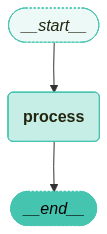

In [20]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

### 그래프 실행

컴파일된 그래프는 `invoke()` 메서드로 실행합니다. 초기 상태를 딕셔너리로 전달하면 그래프가 `START`부터 `END`까지 순차적으로 노드를 실행하며 상태를 업데이트합니다.

아래 코드는 컴파일된 그래프를 실행하고 결과를 확인합니다.

In [21]:
# 그래프 실행
result = graph.invoke({"input": "안녕하세요"})
print(result)

{'input': '안녕하세요', 'result': '처리됨: 안녕하세요'}


## State (상태)

그래프를 정의할 때 가장 먼저 하는 일은 그래프의 `State`를 정의하는 것입니다. State는 그래프 전체에서 공유되는 데이터 구조로, 노드들이 이 상태를 읽고 업데이트하며 협업합니다.

State는 다음 두 가지 요소로 구성됩니다:

1. **스키마(Schema)**: `TypedDict`를 상속하여 정의하는 데이터 구조입니다. 어떤 키가 어떤 타입의 값을 가지는지 명시합니다.

2. **리듀서(Reducer) 함수**: 상태 업데이트 방식을 지정합니다. 기본적으로 새 값이 기존 값을 덮어쓰지만, `Annotated` 타입과 함께 커스텀 리듀서를 지정하면 값을 병합하거나 추가할 수 있습니다.

> 📖 **참고 문서**: [LangGraph State Management](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)

### Schema (스키마)

그래프의 스키마를 지정하는 표준 방법은 `TypedDict`를 사용하는 것입니다. `TypedDict`는 딕셔너리의 각 키와 해당 값의 타입을 명시적으로 정의하여, 타입 안전성과 IDE 자동완성을 지원합니다.

아래 코드는 이름, 나이, 메시지 목록을 포함하는 기본 State 스키마를 정의합니다.

In [22]:
from typing_extensions import TypedDict


# TypedDict를 상속하여 State 스키마 정의
class BasicState(TypedDict):
    name: str  # 사용자 이름
    age: int  # 사용자 나이
    messages: list[str]  # 메시지 목록

### Reducers (리듀서)

리듀서는 노드의 업데이트가 상태에 어떻게 적용되는지 결정합니다. State의 각 키는 독립적인 리듀서를 가질 수 있으며, 리듀서를 지정하지 않으면 기본적으로 새 값이 기존 값을 덮어씁니다.

`Annotated` 타입을 사용하면 커스텀 리듀서를 지정할 수 있습니다. 예를 들어 `operator.add`를 리듀서로 지정하면, 리스트에 새 항목이 추가되는 방식으로 동작합니다.

### 기본 리듀서 (덮어쓰기)

리듀서를 지정하지 않은 필드는 기본 덮어쓰기 동작을 따릅니다. 노드가 해당 키에 새 값을 반환하면, 기존 값이 완전히 새 값으로 대체됩니다.

아래 예시에서 `node_1`이 `foo`를 2로 업데이트하면 기존 값 1이 2로 덮어써지고, `node_2`가 `bar`를 "안녕"으로 업데이트하면 "반가워"가 "안녕"으로 대체됩니다.

아래 코드는 기본 덮어쓰기 리듀서의 동작을 보여주는 예시입니다.

In [23]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END


# 리듀서를 지정하지 않은 기본 State (덮어쓰기 동작)
class State(TypedDict):
    foo: int  # 정수형 필드
    bar: str  # 문자열 필드


def node_1(state: State):
    """첫 번째 노드: foo 값을 2로 업데이트"""
    print(f"node_1 - 현재 상태: {state}")
    return {"foo": 2}  # foo만 업데이트 (bar는 유지)


def node_2(state: State):
    """두 번째 노드: bar 값을 '안녕'으로 업데이트"""
    print(f"node_2 - 현재 상태: {state}")
    return {"bar": "안녕"}  # bar만 업데이트 (foo는 유지)


# 그래프 빌더 생성
builder = StateGraph(State)

# 노드 추가
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# 엣지 추가: START → node_1 → node_2 → END
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# 컴파일 및 실행
graph = builder.compile()

# 초기 상태로 그래프 실행
result = graph.invoke({"foo": 1, "bar": "반가워"})
print(f"최종 결과: {result}")

node_1 - 현재 상태: {'foo': 1, 'bar': '반가워'}
node_2 - 현재 상태: {'foo': 2, 'bar': '반가워'}
최종 결과: {'foo': 2, 'bar': '안녕'}


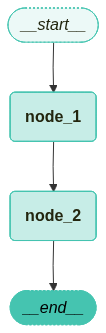

In [24]:
# 기본 리듀서 그래프 시각화
visualize_graph(graph)

### 커스텀 리듀서 (리스트 추가)

`Annotated` 타입과 함께 `operator.add`를 리듀서로 지정하면, 리스트 필드에 새 항목이 기존 리스트에 추가됩니다. 이 방식은 대화 이력, 로그, 중간 결과 등을 누적해야 할 때 유용합니다.

아래 예시에서 `bar` 필드는 `add` 리듀서를 사용하므로, `["기존 항목"]`에 `["새로운 항목"]`이 추가되어 최종적으로 `["기존 항목", "새로운 항목"]`이 됩니다.

아래 코드는 리스트 추가 리듀서의 동작을 보여주는 예시입니다.

In [25]:
from typing import Annotated
from typing_extensions import TypedDict
from operator import add
from langgraph.graph import StateGraph, START, END


# Annotated를 사용하여 리듀서 지정
# add 리듀서: 새 값이 기존 리스트에 추가됨
class State(TypedDict):
    foo: int  # 기본 덮어쓰기 리듀서
    bar: Annotated[list[str], add]  # add 리듀서: 리스트 병합


def node_1(state: State):
    """첫 번째 노드: foo 값만 업데이트"""
    print(f"node_1 - 현재 상태: {state}")
    return {"foo": 2}


def node_2(state: State):
    """두 번째 노드: bar 리스트에 새 항목 추가"""
    print(f"node_2 - 현재 상태: {state}")
    return {"bar": ["새로운 항목"]}  # add 리듀서로 인해 기존 리스트에 추가됨


# 그래프 구성
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

graph = builder.compile()

# 초기 상태로 실행 - bar 리스트에 "새로운 항목"이 추가됨
result = graph.invoke({"foo": 1, "bar": ["기존 항목"]})
print(f"최종 결과: {result}")

node_1 - 현재 상태: {'foo': 1, 'bar': ['기존 항목']}
node_2 - 현재 상태: {'foo': 2, 'bar': ['기존 항목']}
최종 결과: {'foo': 2, 'bar': ['기존 항목', '새로운 항목']}


### Messages를 사용한 상태 관리

대부분의 LLM 애플리케이션은 메시지 기반 대화를 다룹니다. LangGraph는 `add_messages` 리듀서를 제공하여 메시지 목록을 효과적으로 관리할 수 있습니다. 이 리듀서는 새 메시지를 기존 목록에 추가하고, ID가 같은 메시지는 업데이트합니다.

`add_messages`는 단순한 리스트 추가보다 더 지능적으로 동작합니다. 메시지 ID를 기반으로 중복을 처리하고, 메시지 순서를 유지합니다.

아래 코드는 `add_messages` 리듀서를 사용한 대화형 상태 관리 예시입니다.

In [28]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END


# add_messages 리듀서를 사용한 메시지 상태 정의
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]  # 메시지 리스트 (자동 병합)


def chatbot_node(state: MessagesState):
    """챗봇 노드: 마지막 메시지에 응답 생성"""
    last_message = state["messages"][-1]  # 마지막 메시지 추출
    response = f"메시지를 받았습니다: {last_message.content}"
    return {"messages": [AIMessage(content=response)]}  # AI 응답 반환


# 그래프 구성
builder = StateGraph(MessagesState)
builder.add_node("chatbot", chatbot_node)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile()

# HumanMessage로 대화 시작
result = graph.invoke({"messages": [HumanMessage(content="안녕하세요!")]})

# 결과 출력
print("메시지 목록:")
for msg in result["messages"]:
    print(f"- {msg.__class__.__name__}: {msg.content}")

메시지 목록:
- HumanMessage: 안녕하세요!
- AIMessage: 메시지를 받았습니다: 안녕하세요!


### MessagesState

LangGraph는 메시지 기반 상태를 위한 사전 정의된 `MessagesState` 클래스를 제공합니다. 이 클래스를 상속하면 `messages` 필드가 자동으로 `add_messages` 리듀서와 함께 정의됩니다.

추가 필드가 필요한 경우 `MessagesState`를 상속하여 확장할 수 있습니다. 이 방식은 대부분의 대화형 애플리케이션에서 권장됩니다.

아래 코드는 MessagesState를 상속하여 커스텀 필드를 추가하는 예시입니다.

In [29]:
from langgraph.graph import MessagesState


# MessagesState를 상속하여 커스텀 필드 추가
# messages 필드는 자동으로 add_messages 리듀서와 함께 포함됨
class CustomState(MessagesState):
    user_name: str  # 사용자 이름 (추가 필드)
    context: str  # 대화 컨텍스트 (추가 필드)

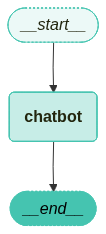

In [30]:
# 노드 예시 그래프 시각화
visualize_graph(graph)

## Nodes (노드)

노드는 그래프의 실제 작업을 수행하는 Python 함수입니다. 각 노드는 현재 상태를 입력으로 받아 처리를 수행하고, 상태 업데이트를 딕셔너리로 반환합니다.

노드 함수는 다음 인자를 받을 수 있습니다:
1. `state`: 그래프의 현재 상태 (필수)
2. `config`: 실행 구성 정보를 포함하는 `RunnableConfig` 객체 (선택)
3. `runtime`: 런타임 컨텍스트 정보 (선택)

노드가 반환하는 딕셔너리의 키는 State에 정의된 키와 일치해야 하며, 해당 키의 리듀서에 따라 상태가 업데이트됩니다.

아래 코드는 기본 노드와 config를 사용하는 노드의 예시입니다.

In [31]:
from typing_extensions import TypedDict
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    input: str  # 입력값
    results: str  # 처리 결과


def plain_node(state: State):
    """기본 노드: state만 사용"""
    return {"results": f"처리됨: {state['input']}"}


def node_with_config(state: State, config: RunnableConfig):
    """config를 사용하는 노드: thread_id 등 설정 정보 접근 가능"""
    # config에서 thread_id 추출 (없으면 "unknown")
    thread_id = config.get("configurable", {}).get("thread_id", "unknown")
    print(f"Thread ID: {thread_id}")
    return {"results": f"안녕, {state['input']}!"}


# 그래프 구성
builder = StateGraph(State)
builder.add_node("plain_node", plain_node)
builder.add_node("node_with_config", node_with_config)
builder.add_edge(START, "plain_node")
builder.add_edge("plain_node", "node_with_config")
builder.add_edge("node_with_config", END)

graph = builder.compile()

# config 매개변수로 thread_id 전달
result = graph.invoke(
    {"input": "테스트"}, config={"configurable": {"thread_id": "thread-1"}}
)
print(f"결과: {result}")

Thread ID: thread-1
결과: {'input': '테스트', 'results': '안녕, 테스트!'}


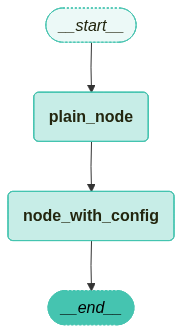

In [32]:
# 일반 엣지 그래프 시각화
visualize_graph(graph)

## Edges (엣지)

엣지는 노드 간의 실행 흐름을 정의합니다. LangGraph는 두 가지 유형의 엣지를 제공합니다:

1. **일반 엣지(Normal Edge)**: `add_edge()`로 정의하며, 항상 고정된 경로를 따릅니다. 노드 A 실행 후 항상 노드 B로 이동합니다.

2. **조건부 엣지(Conditional Edge)**: `add_conditional_edges()`로 정의하며, 라우팅 함수의 결과에 따라 다른 노드로 분기합니다. 상태 기반 동적 라우팅에 사용됩니다.

`START`와 `END`는 특수 노드로, 그래프의 시작점과 종료점을 나타냅니다.

### Normal Edges (일반 엣지)

일반 엣지는 `add_edge(source, target)` 메서드로 정의합니다. 소스 노드 실행이 완료되면 항상 타겟 노드가 실행됩니다. 순차적인 처리 파이프라인을 구성할 때 사용합니다.

아래 예시에서 실행 흐름은 `START → node_a → node_b → END` 순서로 진행됩니다.

아래 코드는 일반 엣지로 순차 워크플로우를 구성하는 예시입니다.

In [35]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    value: str  # 경로 추적용 문자열


def node_a(state: State):
    """노드 A: value에 ' -> A' 추가"""
    print("노드 A 실행")
    return {"value": state["value"] + " -> A"}


def node_b(state: State):
    """노드 B: value에 ' -> B' 추가"""
    print("노드 B 실행")
    return {"value": state["value"] + " -> B"}


# 그래프 구성
builder = StateGraph(State)
builder.add_node("node_a", node_a)
builder.add_node("node_b", node_b)

# 일반 엣지: 항상 고정된 순서로 실행
# START → node_a → node_b → END
builder.add_edge(START, "node_a")
builder.add_edge("node_a", "node_b")
builder.add_edge("node_b", END)

graph = builder.compile()

# 그래프 실행
result = graph.invoke({"value": "시작"})
print(f"결과: {result['value']}")

노드 A 실행
노드 B 실행
결과: 시작 -> A -> B


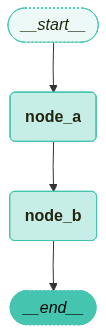

In [36]:
# Command 그래프 시각화: 루프 구조 확인
visualize_graph(graph)

### Conditional Edges (조건부 엣지)

조건부 엣지는 `add_conditional_edges(source, routing_function, path_map)` 메서드로 정의합니다. 라우팅 함수는 현재 상태를 받아 문자열 키를 반환하고, 이 키에 매핑된 노드가 다음에 실행됩니다.

이 패턴은 LLM의 도구 호출 여부, 사용자 입력 검증 결과, 비즈니스 로직에 따른 분기 등 다양한 조건부 워크플로우에 활용됩니다.

아래 예시에서 `value`가 짝수면 `node_b`로, 홀수면 `node_c`로 분기합니다.

아래 코드는 조건부 엣지로 동적 라우팅을 구현하는 예시입니다.

In [43]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    value: int  # 라우팅 조건으로 사용될 숫자
    path: str  # 선택된 경로 기록


def node_a(state: State):
    """노드 A: value 값 유지"""
    print("노드 A 실행")
    return {"value": state["value"]}


def node_b(state: State):
    """노드 B: 짝수 경로 처리"""
    print("노드 B 실행 (짝수 경로)")
    return {"path": "짝수"}


def node_c(state: State):
    """노드 C: 홀수 경로 처리"""
    print("노드 C 실행 (홀수 경로)")
    return {"path": "홀수"}


def routing_function(state: State):
    """라우팅 함수: value가 짝수면 'even', 홀수면 'odd' 반환"""
    if state["value"] % 2 == 0:
        return "even"
    else:
        return "odd"


# 그래프 구성
builder = StateGraph(State)
builder.add_node("node_a", node_a)
builder.add_node("node_b", node_b)
builder.add_node("node_c", node_c)

# 엣지 정의
builder.add_edge(START, "node_a")

# 조건부 엣지: routing_function의 반환값에 따라 분기
# "even" → node_b, "odd" → node_c
builder.add_conditional_edges(
    "node_a", routing_function, {"even": "node_b", "odd": "node_c"}
)
builder.add_edge("node_b", END)
builder.add_edge("node_c", END)

graph = builder.compile()

# 짝수 테스트 (value=4)
print("=== 짝수 테스트 ===")
result = graph.invoke({"value": 4})
print(f"결과: {result}")

print()

# 홀수 테스트 (value=3)
print("=== 홀수 테스트 ===")
result = graph.invoke({"value": 3})
print(f"결과: {result}")

=== 짝수 테스트 ===
노드 A 실행
노드 B 실행 (짝수 경로)
결과: {'value': 4, 'path': '짝수'}

=== 홀수 테스트 ===
노드 A 실행
노드 C 실행 (홀수 경로)
결과: {'value': 3, 'path': '홀수'}


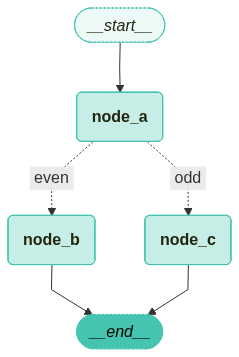

In [44]:
# 조건부 엣지 그래프 시각화
visualize_graph(graph)

## Send

`Send`는 동적으로 여러 노드 인스턴스를 병렬로 생성하여 실행하는 기능입니다. Map-Reduce 패턴을 구현할 때 유용하며, 입력 데이터의 각 항목에 대해 독립적인 처리를 수행할 수 있습니다.

조건부 엣지 함수에서 `Send` 객체의 리스트를 반환하면, 각 `Send`가 지정한 노드가 해당 상태로 병렬 실행됩니다. 모든 병렬 실행이 완료되면 결과가 리듀서를 통해 병합됩니다.

아래 예시에서는 여러 주제에 대해 각각 독립적으로 농담을 생성하고, 결과를 하나의 리스트로 수집합니다.

아래 코드는 Send를 사용한 병렬 처리 예시입니다.

In [39]:
from typing import Annotated
from typing_extensions import TypedDict
from operator import add
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send


# 전체 상태: 주제 목록과 생성된 농담 목록
class OverallState(TypedDict):
    subjects: list[str]  # 농담 주제 목록
    jokes: Annotated[list[str], add]  # 생성된 농담 (add 리듀서로 병합)


# 개별 농담 생성용 상태
class JokeState(TypedDict):
    subject: str  # 단일 주제


def generate_subjects(state: OverallState):
    """주제 생성 노드: 농담을 만들 주제 목록 반환"""
    return {"subjects": ["고양이", "강아지", "새"]}


def generate_joke(state: JokeState):
    """농담 생성 노드: 주제에 대한 농담 생성"""
    joke = f"{state['subject']}에 대한 재미있는 농담"
    return {"jokes": [joke]}  # 리스트로 반환하여 add 리듀서로 병합


def continue_to_jokes(state: OverallState):
    """Send를 사용하여 각 주제에 대해 병렬로 농담 생성 노드 실행"""
    # 각 주제에 대해 Send 객체 생성 → 병렬 실행
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


# 그래프 구성
builder = StateGraph(OverallState)
builder.add_node("generate_subjects", generate_subjects)
builder.add_node("generate_joke", generate_joke)

# 엣지 정의
builder.add_edge(START, "generate_subjects")
# 조건부 엣지에서 Send 리스트 반환 → 병렬 실행
builder.add_conditional_edges("generate_subjects", continue_to_jokes)
builder.add_edge("generate_joke", END)

graph = builder.compile()

# 그래프 실행
result = graph.invoke({"subjects": []})
print(f"생성된 농담: {result['jokes']}")

생성된 농담: ['고양이에 대한 재미있는 농담', '강아지에 대한 재미있는 농담', '새에 대한 재미있는 농담']


## Command

`Command`는 상태 업데이트와 제어 흐름을 하나의 반환 값으로 결합합니다. 노드 함수에서 `Command` 객체를 반환하면, `update` 필드로 상태를 업데이트하고 `goto` 필드로 다음 노드를 직접 지정할 수 있습니다.

이 패턴은 복잡한 분기 로직을 노드 내부에서 처리할 때 유용합니다. 조건부 엣지를 별도로 정의하지 않고도 동적 라우팅을 구현할 수 있습니다.

아래 예시에서 `decision_node`는 카운트에 따라 `continue_node` 또는 `end_node`로 분기합니다.

아래 코드는 Command를 사용한 동적 제어 흐름 예시입니다.

In [40]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command


class State(TypedDict):
    count: int  # 카운터
    status: str  # 현재 상태 메시지


def decision_node(state: State) -> Command[Literal["continue_node", "end_node"]]:
    """결정 노드: count에 따라 다음 노드 결정
    
    Command를 사용하여 상태 업데이트와 다음 노드 지정을 동시에 처리합니다.
    """
    new_count = state["count"] + 1
    if new_count < 3:
        # count가 3 미만이면 continue_node로 이동
        return Command(
            update={"count": new_count, "status": "계속 진행"}, goto="continue_node"
        )
    else:
        # count가 3 이상이면 end_node로 이동
        return Command(update={"count": new_count, "status": "종료"}, goto="end_node")


def continue_node(state: State):
    """계속 노드: 진행 상태 출력"""
    print(f"계속 진행 중... (카운트: {state['count']})")
    return state


def end_node(state: State):
    """종료 노드: 최종 상태 출력"""
    print(f"종료 노드 도달 (카운트: {state['count']})")
    return state


# 그래프 구성
builder = StateGraph(State)
builder.add_node("decision_node", decision_node)
builder.add_node("continue_node", continue_node)
builder.add_node("end_node", end_node)

# 엣지 정의
builder.add_edge(START, "decision_node")
builder.add_edge("continue_node", "decision_node")  # 루프: continue → decision
builder.add_edge("end_node", END)

graph = builder.compile()

# 그래프 실행 (count=0에서 시작, 3번 루프 후 종료)
result = graph.invoke({"count": 0, "status": "시작"})
print(f"최종 상태: {result}")

계속 진행 중... (카운트: 1)
계속 진행 중... (카운트: 2)
종료 노드 도달 (카운트: 3)
최종 상태: {'count': 3, 'status': '종료'}


## Recursion Limit (재귀 제한)

재귀 제한은 단일 실행에서 그래프가 실행할 수 있는 최대 슈퍼 스텝(노드 실행) 수를 제한합니다. 무한 루프를 방지하고 실행 시간을 제어하는 안전장치 역할을 합니다.

`invoke()` 호출 시 `config` 매개변수의 `recursion_limit`으로 설정하며, 기본값은 25입니다. 제한에 도달하면 `GraphRecursionError` 예외가 발생합니다.

복잡한 에이전트에서 많은 반복이 예상되는 경우 이 값을 적절히 조정해야 합니다. 단, 너무 높게 설정하면 무한 루프 상황에서 리소스가 과도하게 소비될 수 있습니다.

아래 코드는 재귀 제한이 동작하는 예시입니다.

In [41]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.errors import GraphRecursionError


class State(TypedDict):
    count: int  # 카운터


def increment_node(state: State):
    """카운트 증가 노드"""
    new_count = state["count"] + 1
    print(f"카운트: {new_count}")
    return {"count": new_count}


def should_continue(state: State):
    """계속 여부 결정: count < 100이면 계속, 아니면 종료"""
    if state["count"] < 100:
        return "continue"
    return "end"


# 그래프 구성
builder = StateGraph(State)
builder.add_node("increment", increment_node)
builder.add_edge(START, "increment")

# 조건부 엣지: 루프 구조
builder.add_conditional_edges(
    "increment", should_continue, {"continue": "increment", "end": END}
)

graph = builder.compile()

# recursion_limit=5로 제한 → 5번 실행 후 GraphRecursionError 발생
try:
    result = graph.invoke({"count": 0}, config={"recursion_limit": 5})
except GraphRecursionError as e:
    print(f"\n재귀 제한 도달: 그래프가 설정된 최대 스텝 수에 도달했습니다.")

카운트: 1
카운트: 2
카운트: 3
카운트: 4
카운트: 5

재귀 제한 도달: 그래프가 설정된 최대 스텝 수에 도달했습니다.


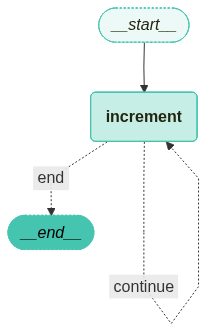

In [42]:
# Recursion Limit 그래프 시각화: 무한 루프 구조 확인
visualize_graph(graph)

---

## 정리

이 튜토리얼에서는 LangGraph의 핵심 구성 요소를 학습했습니다.

### 핵심 개념 요약

| 구성 요소 | 설명 | 주요 메서드/클래스 |
|-----------|------|-------------------|
| **StateGraph** | 상태 기반 워크플로우 정의 | `StateGraph(State)`, `compile()` |
| **State** | 그래프 전체에서 공유되는 데이터 구조 | `TypedDict`, `Annotated` |
| **Reducer** | 상태 업데이트 방식 지정 | `operator.add`, `add_messages` |
| **Node** | 실제 작업을 수행하는 함수 | `add_node(name, func)` |
| **Edge** | 노드 간 실행 흐름 정의 | `add_edge()`, `add_conditional_edges()` |
| **Send** | 동적 병렬 실행 | `Send(node, state)` |
| **Command** | 상태 업데이트 + 제어 흐름 결합 | `Command(update, goto)` |

### 다음 단계

이제 기본적인 그래프 구성 방법을 이해했습니다. 다음 튜토리얼에서는 실제 LLM과 함께 에이전트를 구축하는 방법을 학습합니다.